<a href="https://colab.research.google.com/github/electrojam/Data-Analysis-and-Prediction-Obesity/blob/main/prediccion_de_obesidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
 !pip install  pyjanitor

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.compose
import janitor
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Obtención de datos

In [71]:
# Descargamos el dataset
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [72]:
# Renombramos columnas
df.rename(columns={
    'family_history_with_overweight':'family_overweight',
    'FAVC':'Freq_hcal',
    'FCVC':'Freq_veg',
    'NCP':'Main_meals_day',
    'CAEC':'Freq_between_m',
    'SMOKE':'Smoker',
    'CH2O':'Ingest_h2o',
    'SCC':'Monitor_cal',
    'FAF':'Freq_act_phy',
    'TUE':'Time_use_tec',
    'CALC':'Freq_alcohol',
    'MTRANS':'Main_transp',
    'NObeyesdad':'Obesity_level'
}, inplace = True)

df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_overweight', 'Freq_hcal',
       'Freq_veg', 'Main_meals_day', 'Freq_between_m', 'Smoker', 'Ingest_h2o',
       'Monitor_cal', 'Freq_act_phy', 'Time_use_tec', 'Freq_alcohol',
       'Main_transp', 'Obesity_level'],
      dtype='object')

# EDA y Análisis estadístico

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             2111 non-null   object 
 1   Age                2111 non-null   int64  
 2   Height             2111 non-null   float64
 3   Weight             2111 non-null   float64
 4   family_overweight  2111 non-null   object 
 5   Freq_hcal          2111 non-null   object 
 6   Freq_veg           2111 non-null   float64
 7   Main_meals_day     2111 non-null   float64
 8   Freq_between_m     2111 non-null   object 
 9   Smoker             2111 non-null   object 
 10  Ingest_h2o         2111 non-null   float64
 11  Monitor_cal        2111 non-null   object 
 12  Freq_act_phy       2111 non-null   float64
 13  Time_use_tec       2111 non-null   float64
 14  Freq_alcohol       2111 non-null   object 
 15  Main_transp        2111 non-null   object 
 16  Obesity_level      2111 

#### Estadística descriptiva
Generamos la estasdística descriptiva solo para los datos numéricos.
- count nos dice el número de filas no vacías en una característica.
- La media nos dice el valor medio de esa característica.
- std nos dice el valor de desviación estándar de esa característica.
- min nos dice el valor mínimo de esa característica.
- 25%, 50% y 75% son el percentil/cuartil de cada característica. Esta información del cuartil nos ayuda a detectar valores atípicos.
- max nos dice el valor máximo de esa característica.

In [74]:
df.describe()

,Age,Height,Weight,Freq_veg,Main_meals_day,Ingest_h2o,Freq_act_phy,Time_use_tec
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.315964,1.701620,86.586035,2.418986,2.685651,2.008053,1.010313,0.657861
std,6.357078,0.093368,26.191163,0.533996,0.778079,0.612950,0.850613,0.608926
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.630000,65.470000,2.000000,2.660000,1.585000,0.125000,0.000000
50%,23.000000,1.700000,83.000000,2.390000,3.000000,2.000000,1.000000,0.625000
75%,26.000000,1.770000,107.430000,3.000000,3.000000,2.480000,1.670000,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [75]:
# Verificamos si tienemos algún dato null
df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_overweight,0
Freq_hcal,0
Freq_veg,0
Main_meals_day,0
Freq_between_m,0
Smoker,0


In [76]:
# Verificamos datos duplicados

df.duplicated().sum()

24

In [77]:
# Eliminamos datos duplicados

df.drop_duplicates()

,Gender,Age,Height,Weight,family_overweight,Freq_hcal,Freq_veg,Main_meals_day,Freq_between_m,Smoker,Ingest_h2o,Monitor_cal,Freq_act_phy,Time_use_tec,Freq_alcohol,Main_transp,Obesity_level
0,Female,21,1.62,64.00,yes,no,2.0,3.0,Sometimes,no,2.00,no,0.00,1.000,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.00,yes,no,3.0,3.0,Sometimes,yes,3.00,yes,3.00,0.000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.00,yes,no,2.0,3.0,Sometimes,no,2.00,no,2.00,1.000,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.00,no,no,3.0,3.0,Sometimes,no,2.00,no,2.00,0.000,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.80,no,no,2.0,1.0,Sometimes,no,2.00,no,0.00,0.000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,21,1.71,131.41,yes,yes,3.0,3.0,Sometimes,no,1.73,no,1.68,0.906,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,22,1.75,133.74,yes,yes,3.0,3.0,Sometimes,no,2.01,no,1.34,0.599,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,23,1.75,133.69,yes,yes,3.0,3.0,Sometimes,no,2.05,no,1.41,0.646,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24,1.74,133.35,yes,yes,3.0,3.0,Sometimes,no,2.85,no,1.14,0.586,Sometimes,Public_Transportation,Obesity_Type_III


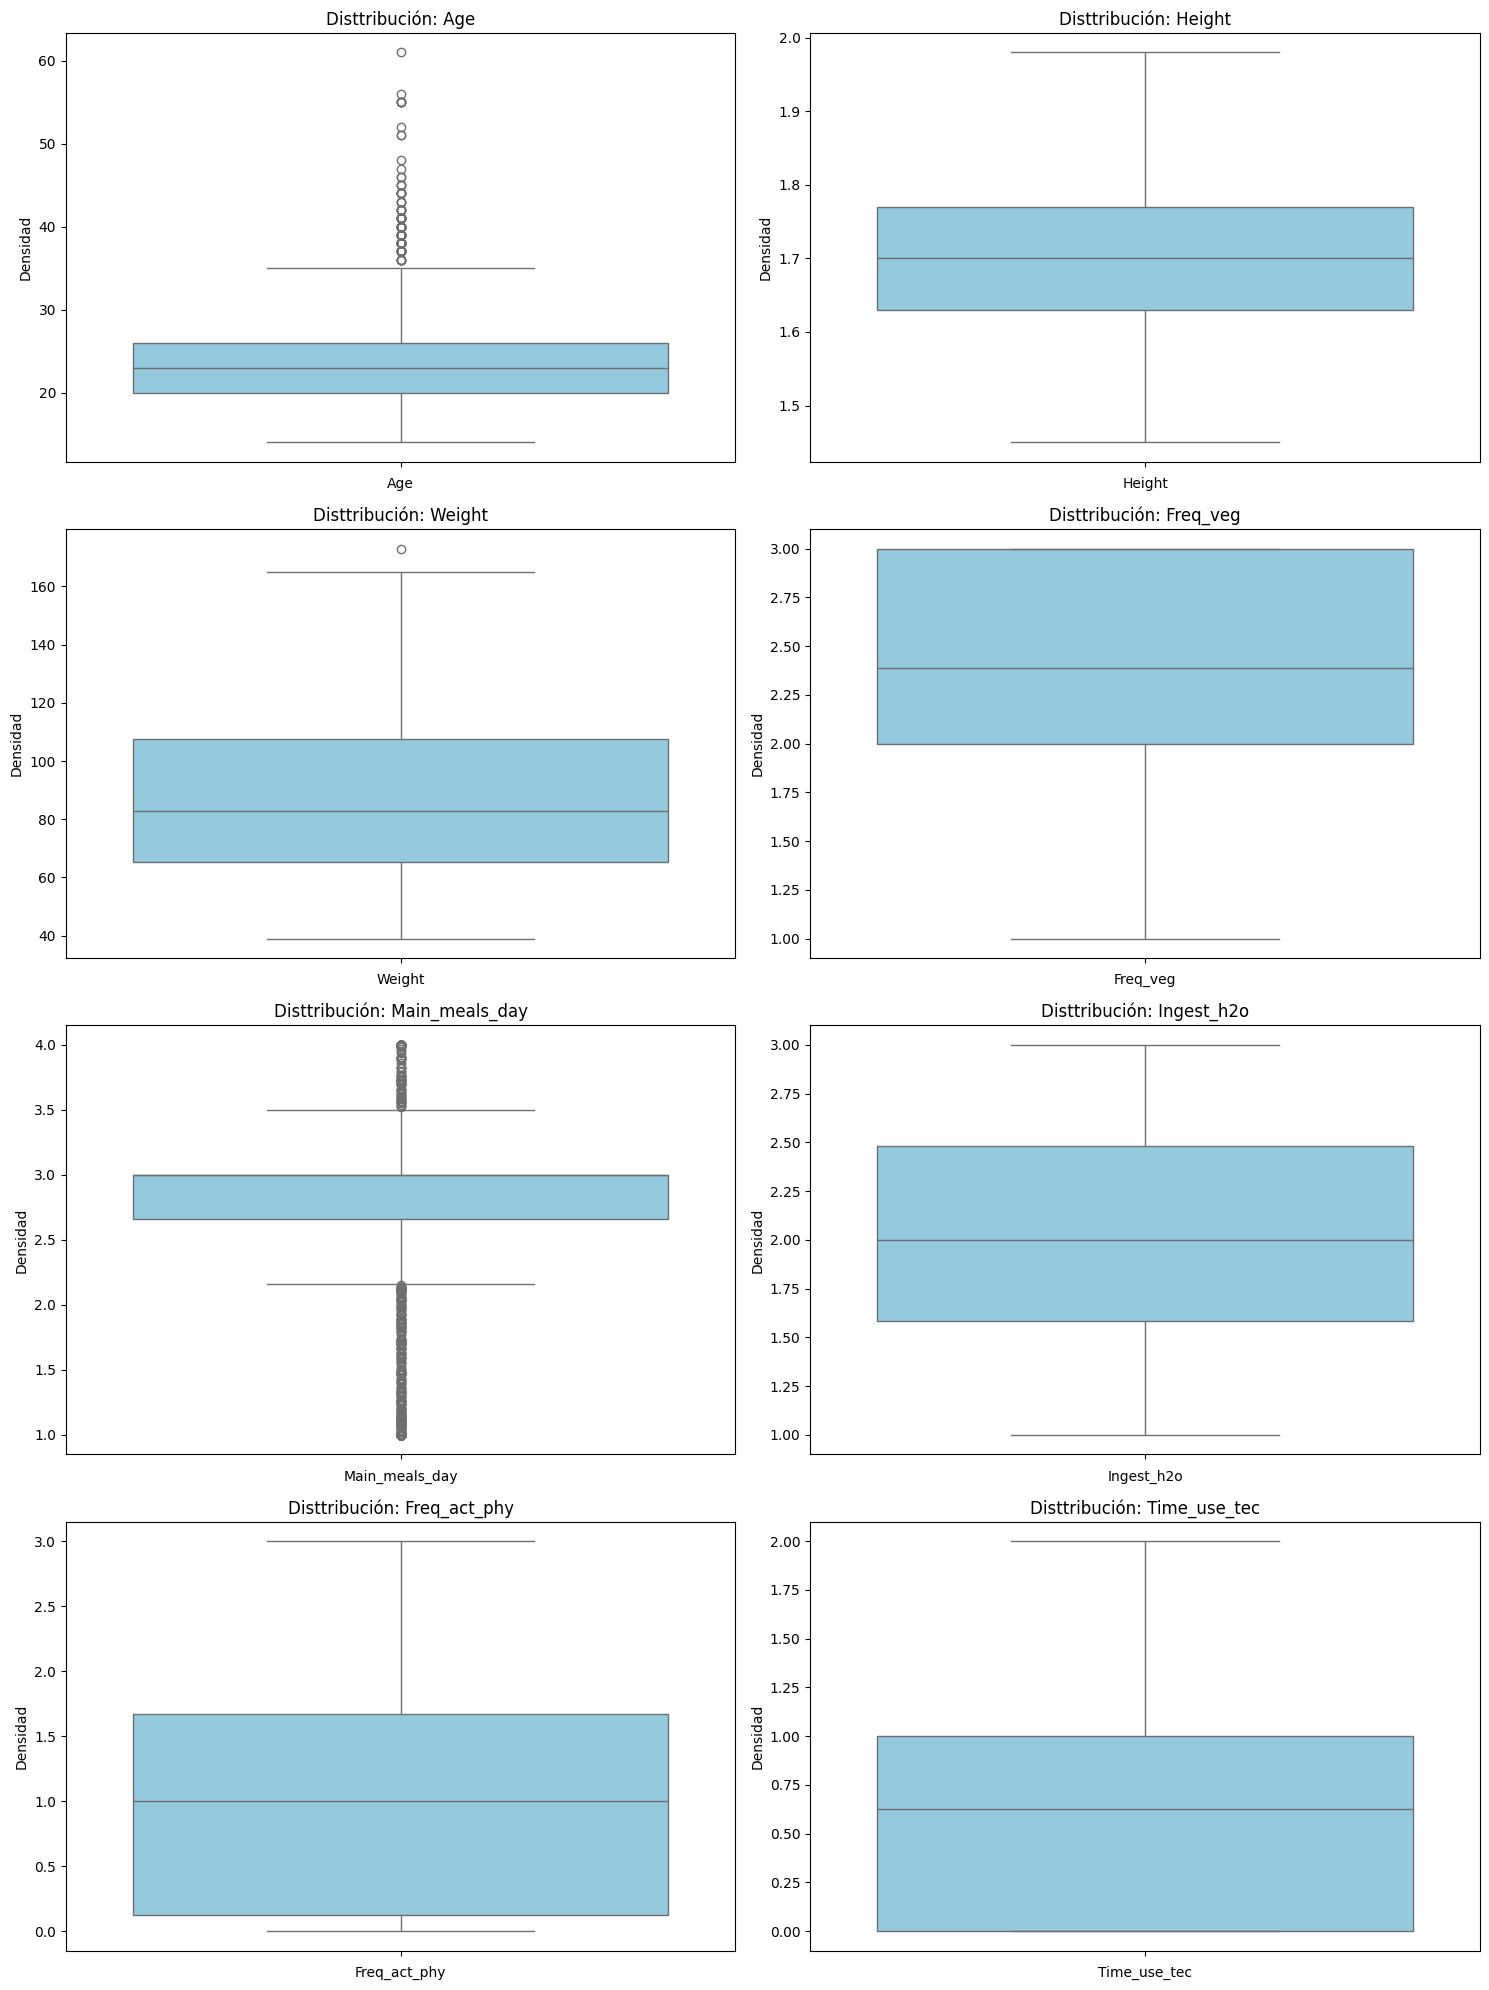

In [78]:
# Graficamos mediante boxplot para analizar percentiles y valores atípicos

numeric_cols = df.select_dtypes(include = [np.number]).columns
num_cols = 2
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols
plt.figure(figsize=(15, num_rows*5))

for i, column in enumerate(numeric_cols, 1):
  plt.subplot(num_rows, num_cols, i)
  sns.boxplot(df[column], color='skyblue')
  plt.title(f"Disttribución: {column}")
  plt.xlabel(column)
  plt.ylabel("Densidad")

plt.tight_layout()
plt.show()

In [79]:
# Revisamos valores de NCP

df['Main_meals_day'].value_counts()

,count
Main_meals_day,
3.00,1208
1.00,205
4.00,74
2.99,17
2.98,13
...,...
1.16,1
3.88,1
3.41,1


In [80]:
# Convertimos columna NCP a int

df['Main_meals_day'] = df['Main_meals_day'].astype('int')

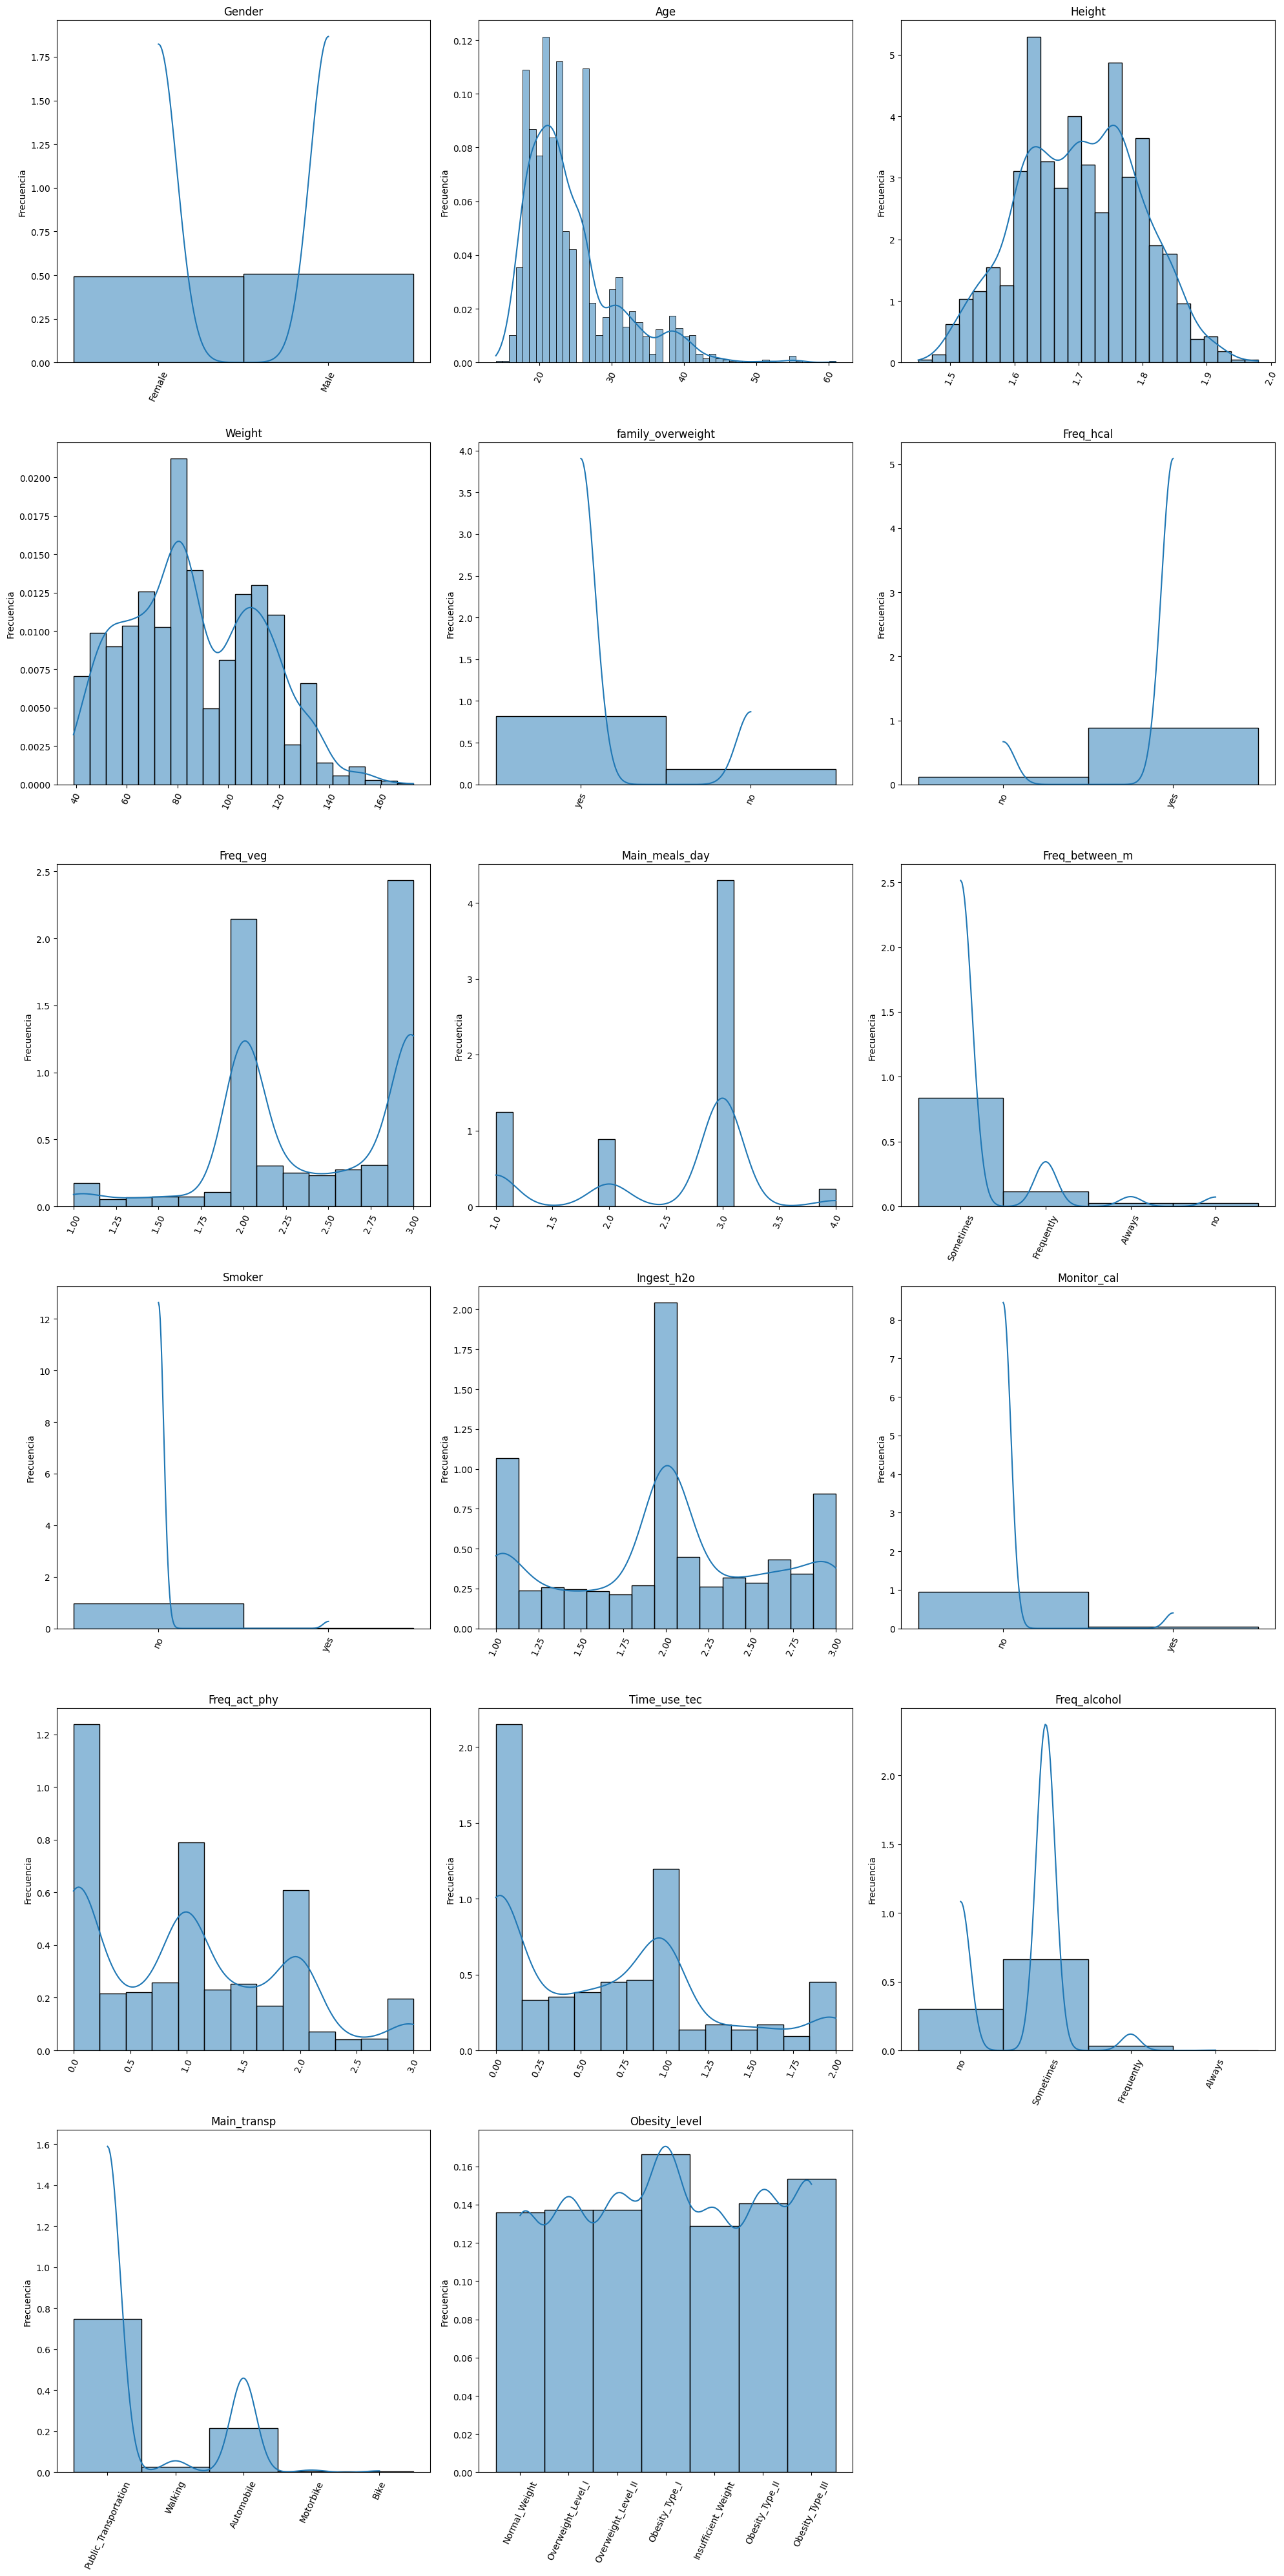

In [81]:
#Graficamos la ditribución de los datos de todas las variables

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 40))
axes = axes.flatten()

for i, column in enumerate(df.columns):
  sns.histplot(df[column], kde=True, stat='density', ax=axes[i])
  axes[i].set_title(column)
  axes[i].set_xlabel('')
  axes[i].set_ylabel('Frecuencia')
  axes[i].tick_params(axis='x', rotation=65)
  #axes[i].set_ylim(emit=True, auto=True)

for j in range(len(df.columns), len(axes)):
  axes[j].axis('off')

plt.tight_layout()

plt.show()

In [82]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_overweight', 'Freq_hcal',
       'Freq_veg', 'Main_meals_day', 'Freq_between_m', 'Smoker', 'Ingest_h2o',
       'Monitor_cal', 'Freq_act_phy', 'Time_use_tec', 'Freq_alcohol',
       'Main_transp', 'Obesity_level'],
      dtype='object')

In [83]:
# Verificamos nuestras variables categóricas
df.select_dtypes(include=[object, "category"]).head()

,Gender,family_overweight,Freq_hcal,Freq_between_m,Smoker,Monitor_cal,Freq_alcohol,Main_transp,Obesity_level
0,Female,yes,no,Sometimes,no,no,no,Public_Transportation,Normal_Weight
1,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight
2,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight
3,Male,no,no,Sometimes,no,no,Frequently,Walking,Overweight_Level_I
4,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II


In [84]:
# aplicamos codificación ordinal de scikitlearn
# para convertir variables categóricas a numéricas

#guardamos nombres de variables  categóricas
categor_columns = df.select_dtypes(include=[object, 'category']).columns

#configuramos nuestro encoder
categor_encoder = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categor_columns),
    remainder = "passthrough"
)

categor_encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['Gender', 'family_overweight', 'Freq_hcal', 'Freq_between_m', 'Smoker',
       'Monitor_cal', 'Freq_alcohol', 'Main_transp', 'Obesity_level'],
      dtype='object'))])

In [85]:
# aplicamos la codifiación
# también renombramos los nombres de las columnas

df_transformed = (
    pd.DataFrame(
        categor_encoder.fit_transform(df),
        columns = categor_encoder.get_feature_names_out(),  # recuperamos nombres de columnas del df
        index = df.index
    ).rename( # renombramos columnas del df transformado
        columns = lambda x: x.removeprefix("ordinalencoder__")
    ).rename( # renombramos columnas del df transformado
        columns = lambda x: x.removeprefix("remainder__")
    )
)

df_transformed.head()

,Gender,family_overweight,Freq_hcal,Freq_between_m,Smoker,Monitor_cal,Freq_alcohol,Main_transp,Obesity_level,Age,Height,Weight,Freq_veg,Main_meals_day,Ingest_h2o,Freq_act_phy,Time_use_tec
0,0.0,1.0,0.0,2.0,0.0,0.0,3.0,3.0,1.0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0
1,0.0,1.0,0.0,2.0,1.0,1.0,2.0,3.0,1.0,21.0,1.52,56.0,3.0,3.0,3.0,3.0,0.0
2,1.0,1.0,0.0,2.0,0.0,0.0,1.0,3.0,1.0,23.0,1.80,77.0,2.0,3.0,2.0,2.0,1.0
3,1.0,0.0,0.0,2.0,0.0,0.0,1.0,4.0,5.0,27.0,1.80,87.0,3.0,3.0,2.0,2.0,0.0
4,1.0,0.0,0.0,2.0,0.0,0.0,2.0,3.0,6.0,22.0,1.78,89.8,2.0,1.0,2.0,0.0,0.0


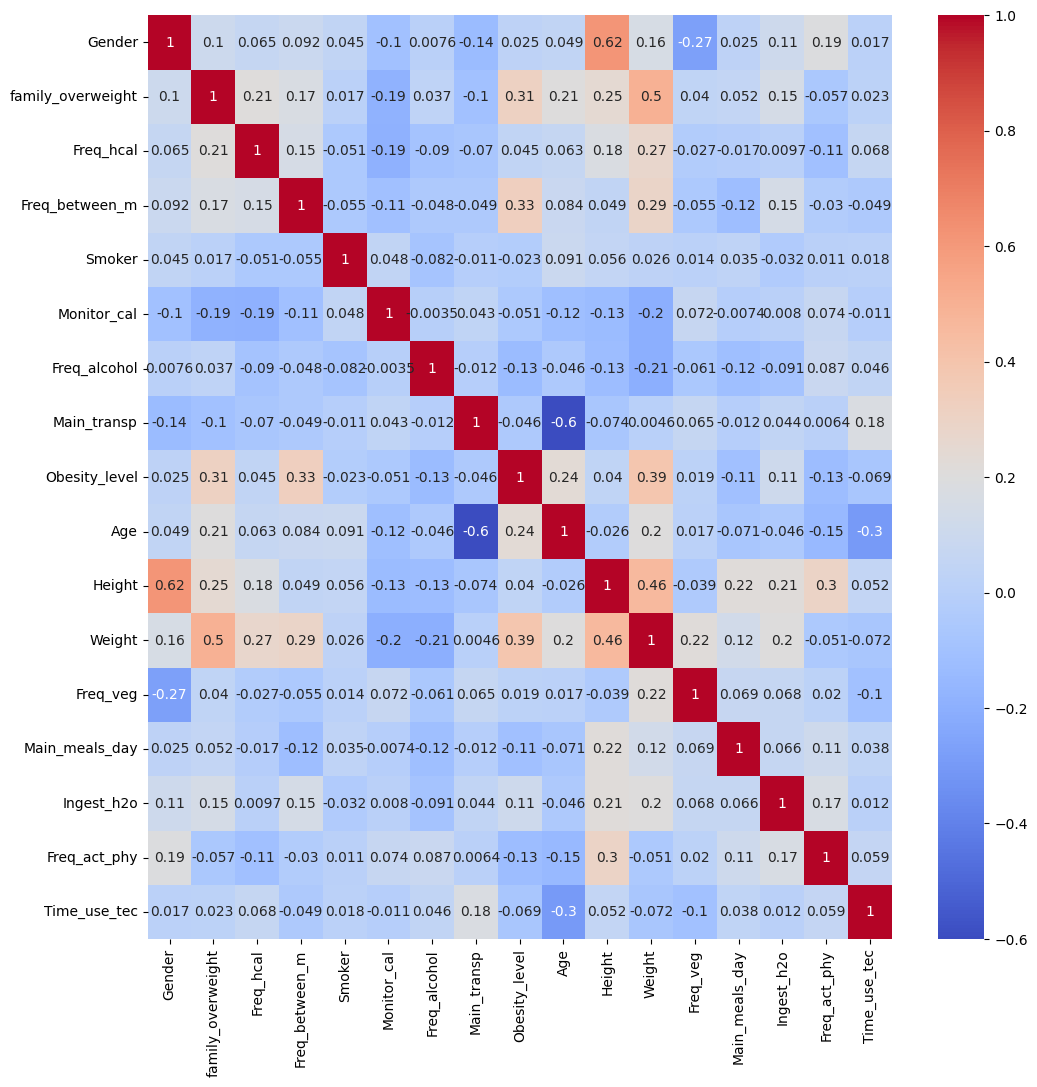

In [86]:
# Visualizamos matriz de correlación entre variables numéricas

plt.figure(figsize=(12,12))
sns.heatmap(df_transformed.corr(), cmap="coolwarm", annot=True)
plt.show()

# Modelos de Machine Learning


In [87]:
# Standarizamos los datos con StandardScaler de scikit learn
# para que sean mejor interpretados por el modelo ML.

# Dividimos datos en x y y

x = df_transformed.drop(["Obesity_level"], axis=1)
y = df_transformed['Obesity_level']

# Separamos datos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# escalamos los datos
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [88]:
# Creamos dict con modelos escogidos de machine learning

models = {
    "KNN":KNeighborsClassifier(),
    "Decision Tree Classifier":DecisionTreeClassifier(),
    "Random Forest Classifier":RandomForestClassifier(),
    "Gradient Boosting Classfifier":GradientBoostingClassifier(),
    "Ada Boost Classifier":AdaBoostClassifier(),
    "Logistic Regresion":LogisticRegression()

}

In [89]:
# Creamos dict con llaves valor de nombre de modelos y métricas vacío

metrics = {
    "Model":[],
    "Accuracy":[],
    "Precision":[],
    "Recall":[]
}

# en un bucle entrenamos con cada modelo ML y hacemos pruebas,
# tambien calculamos las métricas accuracy, f1_score, recall, precision_score
# y guardamos en dict metrics

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average="weighted")
  recall = recall_score(y_test, y_pred, average="weighted")
  precision = precision_score(y_test, y_pred, average="weighted")
  metrics["Model"].append(name)
  metrics["Accuracy"].append(acc * 100)
  metrics["Precision"].append(precision * 100)
  metrics["Recall"].append(recall * 100)
  print(f"Model: {name}")
  print(f"Accuracy: {acc*100}")
  print(f"Precision: {precision*100}")
  print(f"F1 score: {f1}")
  print(f"Recall: {recall}")
  print("-" * 30)



Model: KNN
Accuracy: 81.62878787878788
Precision: 81.31150462841005
F1 score: 0.8077480844867615
Recall: 0.8162878787878788
------------------------------
Model: Decision Tree Classifier
Accuracy: 91.47727272727273
Precision: 91.48493372320604
F1 score: 0.9144768408140569
Recall: 0.9147727272727273
------------------------------
Model: Random Forest Classifier
Accuracy: 94.31818181818183
Precision: 94.5775231254653
F1 score: 0.9437697615967486
Recall: 0.9431818181818182
------------------------------
Model: Gradient Boosting Classfifier
Accuracy: 94.31818181818183
Precision: 94.34135706862978
F1 score: 0.942974610547896
Recall: 0.9431818181818182
------------------------------
Model: Ada Boost Classifier
Accuracy: 47.53787878787879
Precision: 45.00560058227326
F1 score: 0.396619356012694
Recall: 0.4753787878787879
------------------------------
Model: Logistic Regresion
Accuracy: 85.79545454545455
Precision: 86.09079597466408
F1 score: 0.8536082687270117
Recall: 0.8579545454545454
----

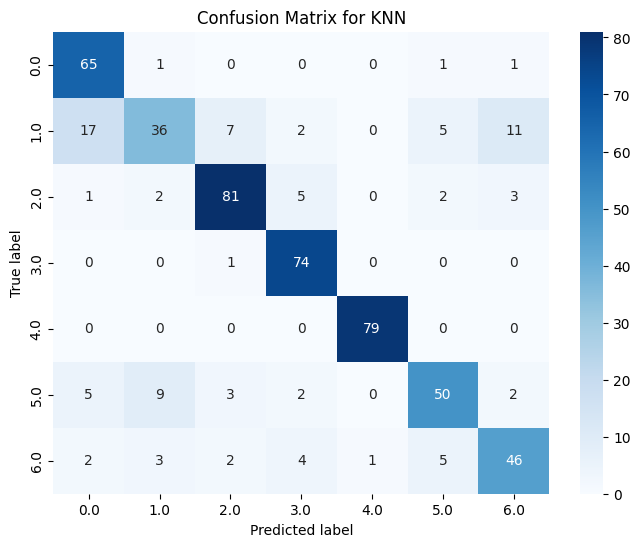

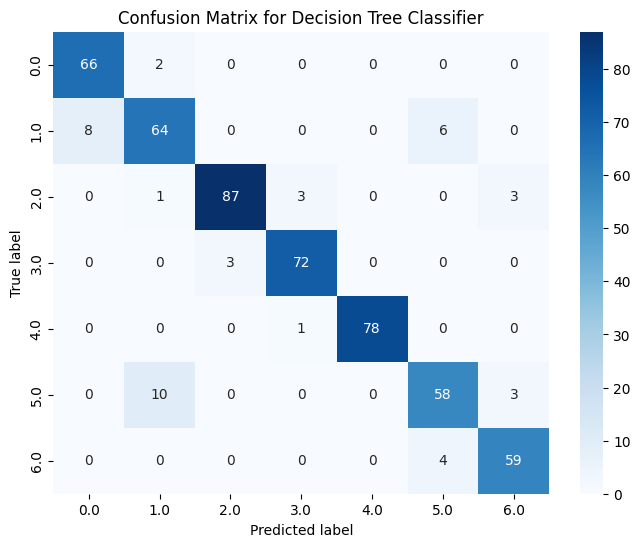

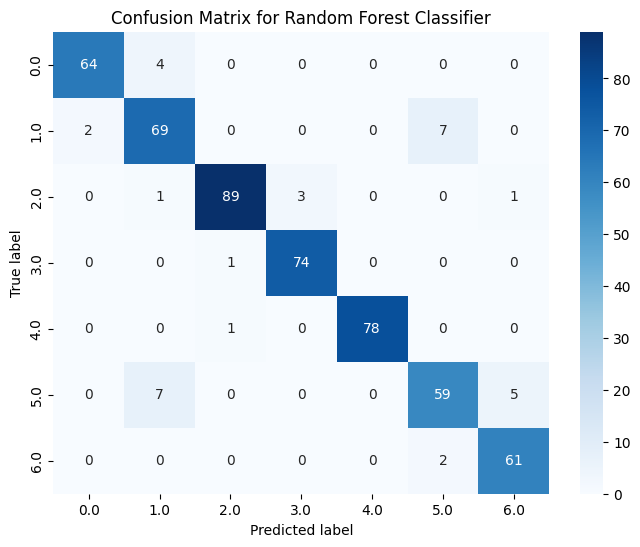

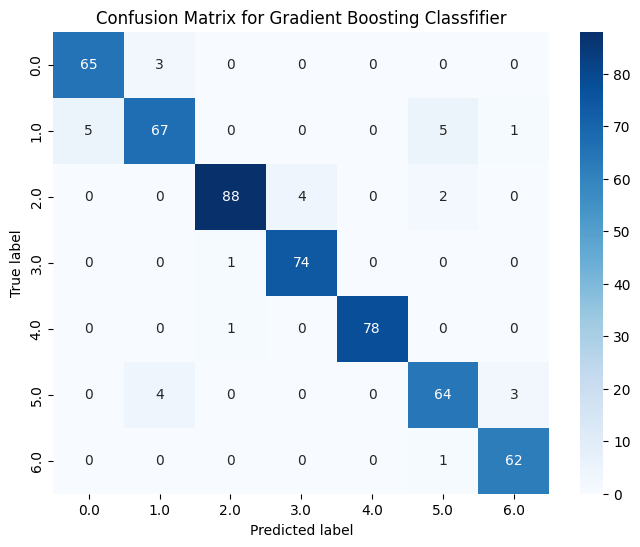

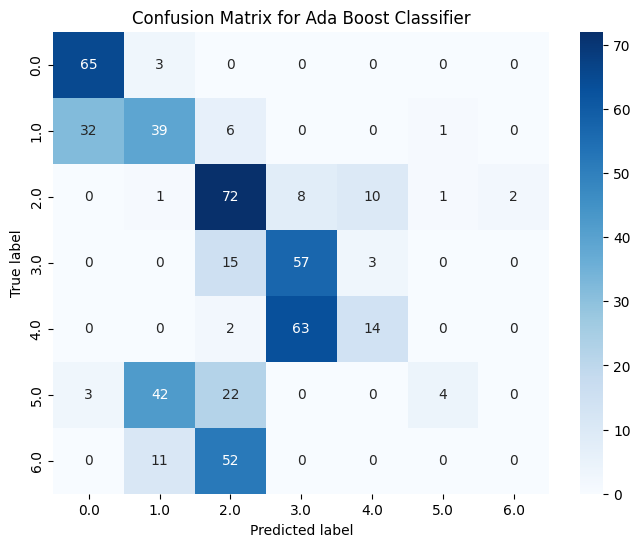

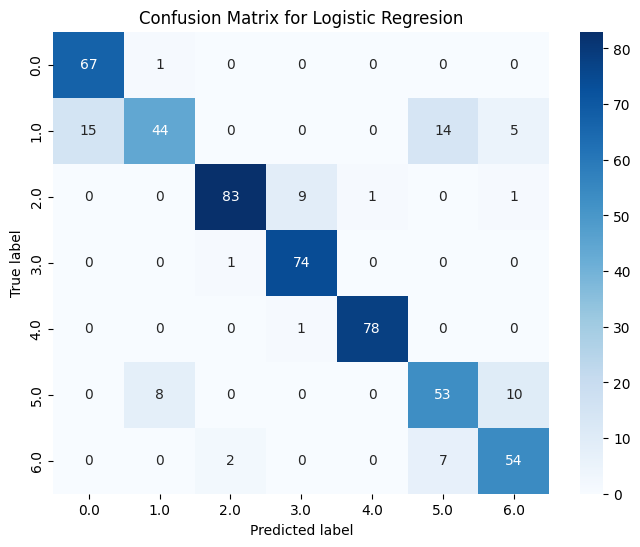

In [90]:
# Visualizamos matrices de confusión de cada modelo de ML

accuracy_results = {}

for name, clf in models.items():
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
  plt.title(f"Confusion Matrix for {name}")
  plt.xlabel("Predicted label")
  plt.ylabel("True label")
  plt.show()

In [91]:
categor_encoder.named_transformers_.ordinalencoder.inverse_transform(X = df_transformed[categor_columns])

array([['Female', 'yes', 'no', ..., 'no', 'Public_Transportation',
        'Normal_Weight'],
       ['Female', 'yes', 'no', ..., 'Sometimes', 'Public_Transportation',
        'Normal_Weight'],
       ['Male', 'yes', 'no', ..., 'Frequently', 'Public_Transportation',
        'Normal_Weight'],
       ...,
       ['Female', 'yes', 'yes', ..., 'Sometimes',
        'Public_Transportation', 'Obesity_Type_III'],
       ['Female', 'yes', 'yes', ..., 'Sometimes',
        'Public_Transportation', 'Obesity_Type_III'],
       ['Female', 'yes', 'yes', ..., 'Sometimes',
        'Public_Transportation', 'Obesity_Type_III']], dtype=object)

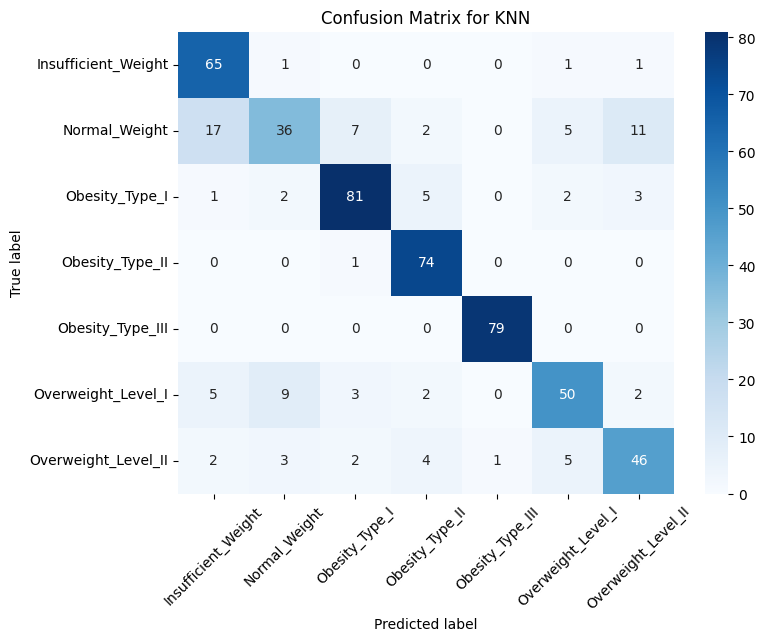

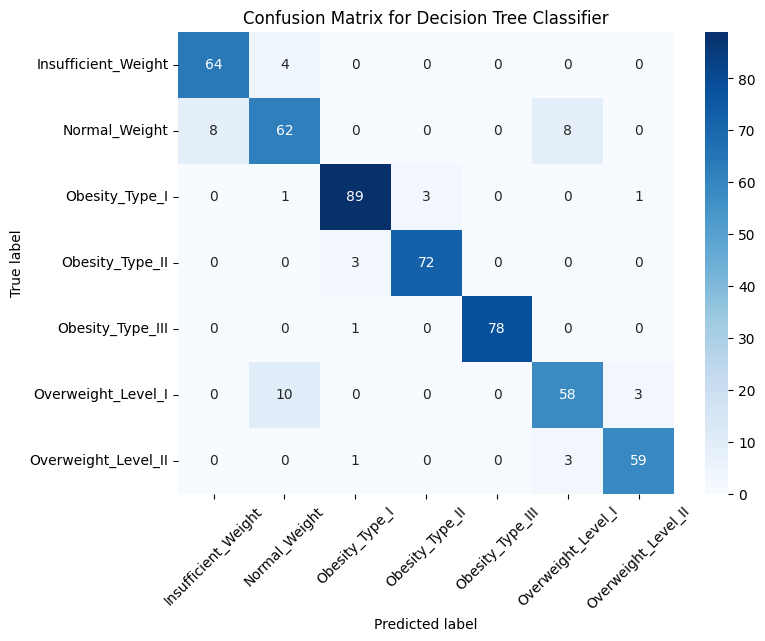

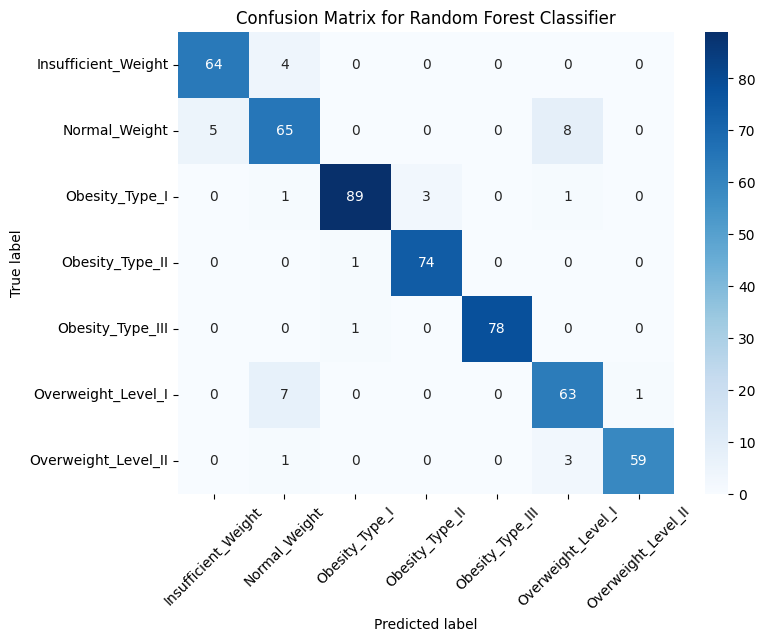

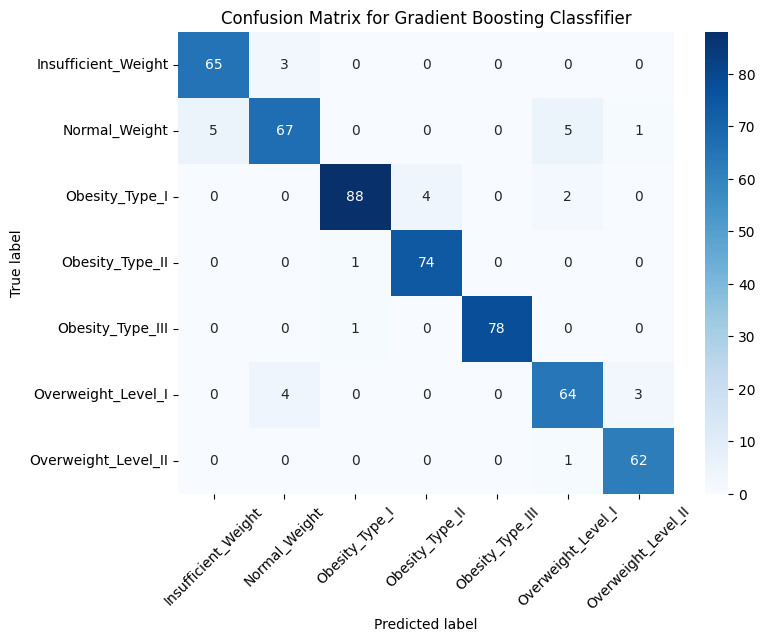

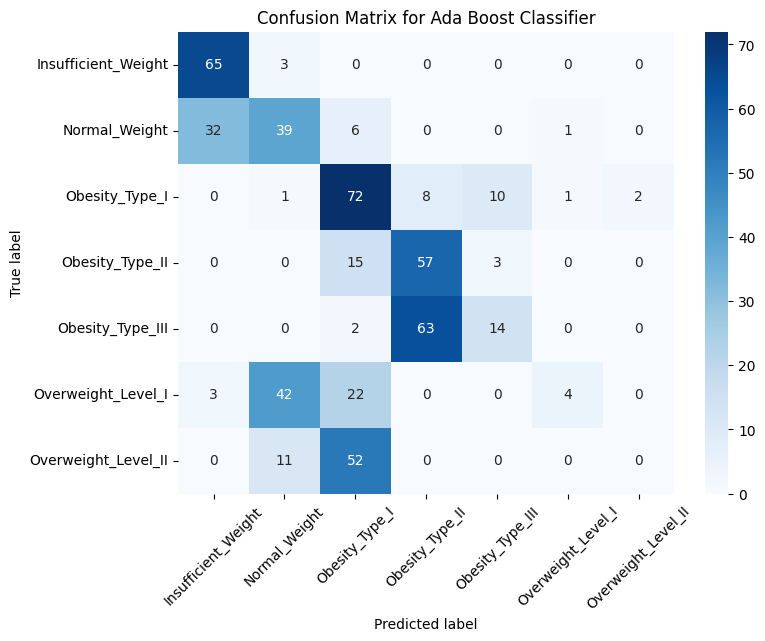

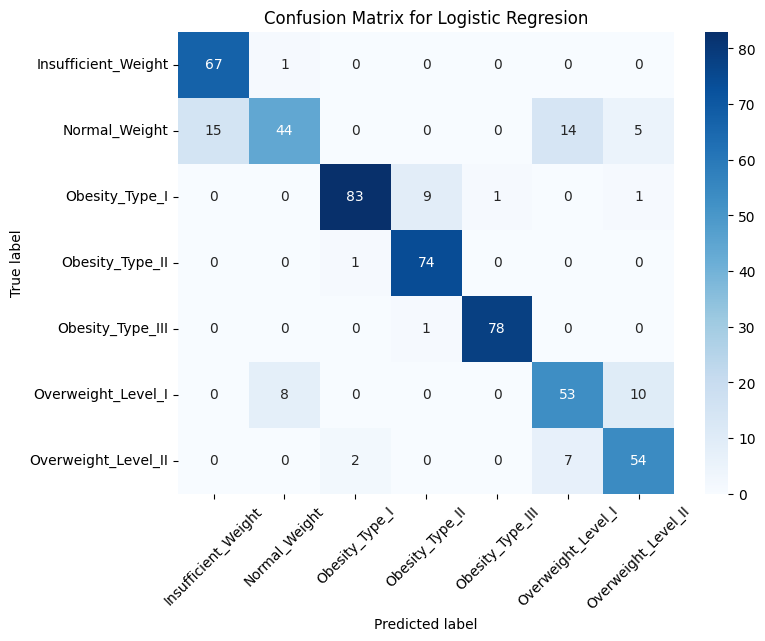

In [92]:
# Visualizamos matrices de confusión de cada modelo de ML

# obtenenmos etiquetas originas de variable Obesity_levels
original_labels = categor_encoder.named_transformers_['ordinalencoder'].categories_[8]

accuracy_results = {}

for name, clf in models.items():
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=original_labels, yticklabels=original_labels)
  plt.title(f"Confusion Matrix for {name}")
  plt.xlabel("Predicted label")
  plt.xticks(rotation=45)
  plt.ylabel("True label")
  plt.show()

<Figure size 1400x600 with 0 Axes>

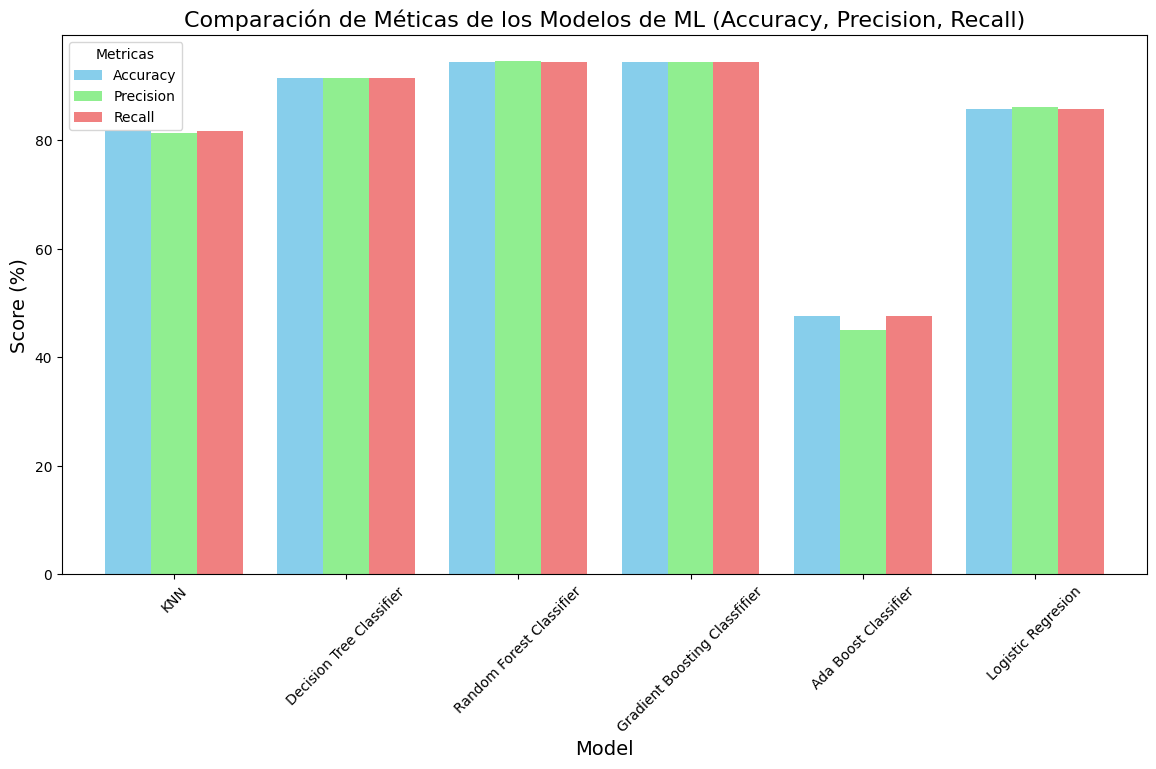

In [93]:
# Calculamos y visualizamos las métricas de los modelos de ML
# en una sola gráfica de barras

metrics_df = pd.DataFrame(metrics)
plt.figure(figsize=(14,6))
metrics_df.set_index("Model").plot(kind='bar', width=0.8, figsize=(14,7), color=["skyblue", "lightgreen", "lightcoral"])
plt.title("Comparación de Méticas de los Modelos de ML (Accuracy, Precision, Recall)", fontsize=16)
plt.ylabel("Score (%)", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Metricas", loc="upper left")
plt.show()

